In [2]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd

import importlib

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import policies
import bbDebiasing as bbDebias
import maxEnsembleDebias as maxDebias

import matplotlib.pyplot as plt

import time

In [104]:
# reading in the data
data = pd.read_csv('../options500', index_col=0)

# check for nans
data.isna().sum()

date                           0
strikes_spread_OSPN            0
calls_contracts_traded_OSPN    0
puts_contracts_traded_OSPN     0
calls_open_interest_OSPN       0
                              ..
hv_90_PTCT                     0
hv_120_PTCT                    0
hv_180_PTCT                    0
hv_200_PTCT                    0
VIX_PTCT                       0
Length: 1036, dtype: int64

In [105]:
# handle or drop date column
data = data.drop(columns='date')

In [36]:
covariates = list(data.columns)
targets = []

target_names = ['DITM_IV', 'ITM_IV', 'sITM_IV', 'ATM_IV', 'sOTM_IV', 'OTM_IV', 'DOTM_IV']
for name in target_names:
    for f in covariates:
        if name in f:
            targets.append(f)
            covariates.remove(f)

In [37]:
X = data[covariates].values
Y = data[targets].values 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Training two gradient boosting regressors, one on for each of the first two (of 315 total) targets.

In [39]:
gb1 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb1.fit(X_train, Y_train[:,0])


gb2 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb2.fit(X_train, Y_train[:,1])


GradientBoostingRegressor(max_depth=6, random_state=42)

Verifying that the error is at least sort of on correct scale for the data.

In [42]:
print(f"Min OT Value: {Y_train.min()}")
print(f"Max OT Value: {Y_train.max()}")
preds1 = gb1.predict(X_test)
preds2 = gb2.predict(X_test)
print(f"MSE of predictor on 1st target {mse(Y_test[:,0], preds1)}")
print(f"MSE of predictor on 2nd target {mse(Y_test[:,1], preds2)}")

Min OT Value: 3.25
Max OT Value: 148.15
MSE of predictor on 1st target 71.22913546029069
MSE of predictor on 2nd target 22.799666599409637


Building two composite predictors, which each use gradient boosting for one coordinate of prediction vector and predict label mean for other coordinate.  

In [74]:
def h1(xs):
    # verify that this should in fact take the prediction of the first column and then pad the rest
    arr = np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
    col1 = gb1.predict(xs)
    arr[:,0] = col1
    return arr


def h2(xs):
    # verify that this should take the prediction of the second column and then pad the rest
    arr = np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
    col2 = gb2.predict(xs)
    arr[:,1] = col2
    return arr

In [75]:
arr = np.full([len(X_train), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
col1 = gb1.predict(X_train)
arr[:,0] = col1

Building policies. For now, just the basic simplex policies.

In [81]:
policy1 = policies.Simplex(len(Y_train[0]), h1)
policy2 = policies.Simplex(len(Y_train[0]), h2)

# Bias Bounties Method

In [98]:
def init_model(xs):
    # col1 = np.full(len(xs), Y_train[:,0].mean())
    # col2 = np.full(len(xs), Y_train[:,1].mean())
    # return np.column_stack((col1, col2))
    return np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])

init_policy = policies.Simplex(len(Y_train[0]), init_model)

max_depth = 1000
tolerance = 0.01
bbModel = bbDebias.bbDebias(init_model, init_policy, X_train, Y_train, max_depth, tolerance)
bbModel.debias([h1,h2], [policy1, policy2])

Maximum depth reached.


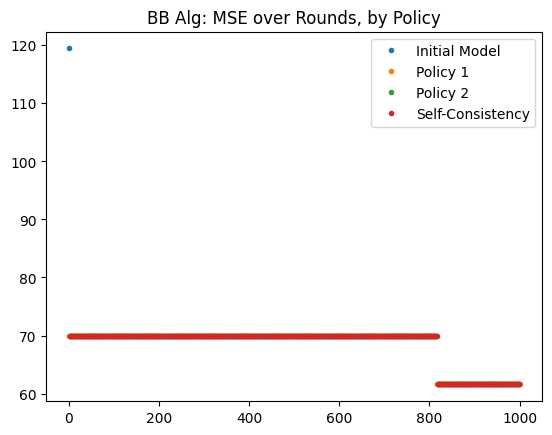

In [99]:
mses = np.array([mse(Y_train, pred, multioutput='raw_values') for pred in bbModel.predictions_by_round])

coord = 0
plt.plot(0,mses[0][coord],'.', label="Initial Model")
for i in range(1, bbModel.n_models+1):
    indices = list(range(len(bbModel.predictions_by_round)))[i::(bbModel.n_models + 1)]
    plt.plot(indices, mses[i::(bbModel.n_models + 1)][:, coord], '.', label=f"Policy {i}")
indices = list(range(len(bbModel.predictions_by_round)))[(bbModel.n_models+1)::(bbModel.n_models + 1)]
plt.plot(indices, mses[(bbModel.n_models+1)::(bbModel.n_models + 1)][:, coord], '.', label="Self-Consistency")
plt.legend()
plt.title("BB Alg: MSE over Rounds, by Policy");

Comparison of MSE of our final model vs the MSEs of the original models in the first coordinate:

In [100]:
print(f"(Training) MSE of our model in 1st coordinate: {mses[-1][0]}")
print(f"(Training) MSE of model 1 in 1st coordinate:  {mse(Y_train, h1(X_train), multioutput='raw_values')[0]}")
print(f"(Training) MSE of model 2 in 1st coordinate: {mse(Y_train, h2(X_train), multioutput='raw_values')[0]}")

(Training) MSE of our model in 1st coordinate: 61.56642698548402
(Training) MSE of model 1 in 1st coordinate:  3.7359070438953985
(Training) MSE of model 2 in 1st coordinate: 119.4435328078223


I.e., at least with the naive simplex policy, we don't match performance of the better of the two initial predictors in terms of squared error. 

Comparison of MSE overall:

In [101]:
print(f"(Training) MSE of our model: {mses[-1].mean()}")
print(f"(Training) MSE of model 1:  {mse(Y_train, h1(X_train))}")
print(f"(Training) MSE of model 2: {mse(Y_train, h2(X_train))}")

(Training) MSE of our model: 83.31123487475548
(Training) MSE of model 1:  96.71069636749795
(Training) MSE of model 2: 96.84005617455229


So, we do better overall than the original models. 

Text(0.5, 1.0, 'BB Alg: Predicted and Realized Objective over Rounds')

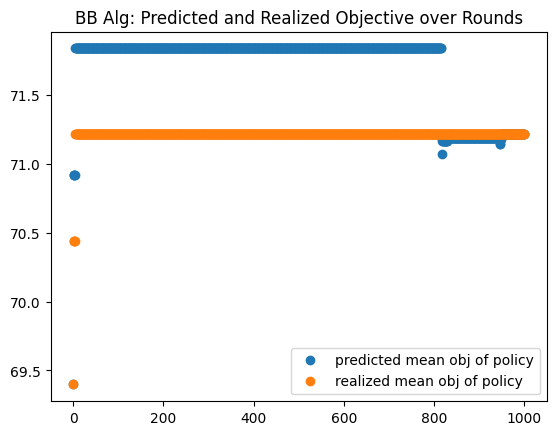

In [106]:
# predicted objective of each point per round
pred_rev = [np.einsum('ij,ij->i', bbModel.predictions_by_round[i], init_policy.run_given_preds(bbModel.predictions_by_round[i])) for i in range(len(bbModel.predictions_by_round))] #fancy vectorized row-wise dot product 
# realized objective
true_rev = [np.einsum('ij,ij->i', Y_train, init_policy.run_given_preds(bbModel.predictions_by_round[i])) for i in range(len(bbModel.predictions_by_round))]


plt.plot(range(len(bbModel.predictions_by_round)), np.mean(pred_rev, axis=1), 'o', label="predicted mean obj of policy")
plt.plot(range(len(bbModel.predictions_by_round)), np.mean(true_rev, axis=1), 'o', label="realized mean obj of policy")
plt.legend()
plt.title("BB Alg: Predicted and Realized Objective over Rounds")

# Max Ensemble Method

In [93]:
max_depth =1000
tolerance = 0.1
maxModel = maxDebias.EnsembledModel([h1,h2], [policy1, policy2], X_train, Y_train, max_depth, tolerance)
maxModel.debias()

Maximum depth reached.


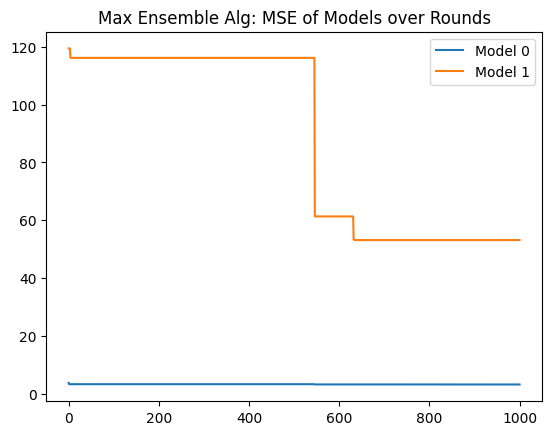

In [94]:
preds = np.array(maxModel.predictions_by_round)

preds_by_model = [preds[:,i] for i in range(maxModel.n_models)]
mses_by_model = np.zeros((len(preds_by_model), len(preds), maxModel.pred_dim))
for i in range(maxModel.n_models):
    for j in range(len(preds_by_model[i])):
        mses_by_model[i][j] = mse(Y_train, preds_by_model[i][j], multioutput='raw_values')

coord = 0
for i in range(maxModel.n_models):
    plt.plot(np.arange(len(maxModel.predictions_by_round)), mses_by_model[i][:,coord], label=f"Model {i}")
plt.legend()
plt.title("Max Ensemble Alg: MSE of Models over Rounds");

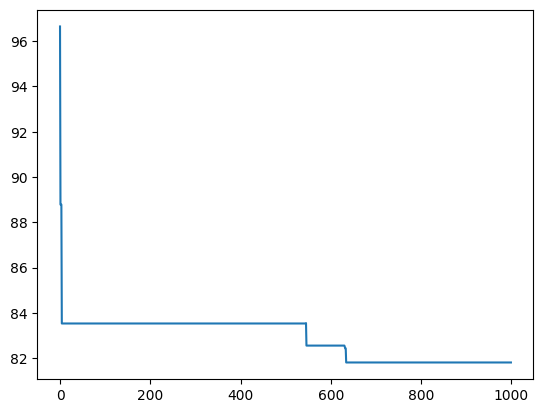

In [95]:
ensemble_mse = np.array([mse(Y_train, maxModel.meta_model_pred_by_round[i]) for i in range(len(maxModel.meta_model_pred_by_round))])
coord = 0

plt.plot(np.arange(len(ensemble_mse)), ensemble_mse)

Comparing final MSEs of meta algorithm, BB method, and original models

In [96]:
print(f"(Training) MSE of BB Model in 1st coordinate: {mse(Y_train, bbModel.predictions_by_round[-1], multioutput='raw_values')[0]}")
print(f"(Training) MSE of Max Ensemble Model in 1st coordinate: {mse(Y_train, maxModel.meta_model_pred_by_round[-1], multioutput='raw_values')[0]}")
print(f"(Training) MSE of Model 1 in 1st coordinate:  {mse(Y_train, h1(X_train), multioutput='raw_values')[0]}")
print(f"(Training) MSE of Model 2 in 1st coordinate: {mse(Y_train, h2(X_train), multioutput='raw_values')[0]}")

(Training) MSE of BB Model in 1st coordinate: 69.92925380058637
(Training) MSE of Max Ensemble Model in 1st coordinate: 6.285508018917751
(Training) MSE of Model 1 in 1st coordinate:  3.7359070438953985
(Training) MSE of Model 2 in 1st coordinate: 119.4435328078223


And overall MSE

In [97]:
print(f"(Training) MSE of BB Model: {mse(Y_train, bbModel.predictions_by_round[-1])}")
print(f"(Training) MSE of Max Ensemble Model: {ensemble_mse[-1]}")
print(f"(Training) MSE of Model 1:  {mse(Y_train, h1(X_train))}")
print(f"(Training) MSE of Model 2: {mse(Y_train, h2(X_train))}")

(Training) MSE of BB Model: 84.71430707348631
(Training) MSE of Max Ensemble Model: 81.81313197315094
(Training) MSE of Model 1:  96.71069636749795
(Training) MSE of Model 2: 96.84005617455229


# Varun: stopped here

# Comparing Methods on Objective

# Testing Policy

Note: Something wrong with this policy. Initial sanity checks passed, but when run on whole dataset, model never updates. Need to investigate more, but currently runs too slowly (e.g. overnight).


Running on very small subset of data

In [ ]:
# importlib.reload(policies)
# policy = policies.ElectricTransformer(2, h1, 0.1, 25)
# alloc = policy.run_given_preds(Y_train[0:5])

i 0


/opt/anaconda3/envs/bb-portfolio/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Checking that constraints met

In [ ]:
# print("Allocation: \n", alloc)
# print("Predictions: \n", Y_train[0:5])
# print("Dot product: ", np.einsum('ij,ij->i', Y_train[0:5], alloc))
# print("Sum of weights accross allocations: ", alloc.sum(axis=1))
# print("Violations of min allocation? ", np.sum(alloc<0))
# print("Violations of max allocation? ", np.sum(alloc>1))

Allocation: 
 [[3.87780077e-01 6.12219923e-01]
 [6.77439029e-12 1.00000000e+00]
 [4.22319282e-01 5.77680718e-01]
 [1.56929188e-01 8.43070812e-01]
 [4.30984071e-01 5.69015929e-01]]
Predictions: 
 [[16.25       40.83499908]
 [ 2.74399996 11.19649982]
 [17.09399986 43.2765007 ]
 [12.10000038 29.6534996 ]
 [21.87800026 43.9355011 ]]
Dot product:  [31.30142624 11.19649982 32.21912574 26.89884323 34.4290696 ]
Sum of weights accross allocations:  [1. 1. 1. 1. 1.]
Violations of min allocation?  0
Violations of max allocation?  0


Timing how long optimization runs on whole dataset

In [ ]:

# start_time = time.time()
# alloc = policy.run_given_preds(Y_test)

# # Record the end time
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

i 0


/opt/anaconda3/envs/bb-portfolio/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


i 1000
i 2000
i 3000
i 4000
i 5000
i 6000
i 7000
i 8000
i 9000
i 10000
i 11000
i 12000
i 13000


In [ ]:
elapsed_time

71.14155411720276